In [35]:
import numpy as np
import matplotlib.pyplot as plt

On génére 1000 valeurs de temps qui varient de 0 a 10 s et on garde le pas qu'on donne : 

In [36]:
tps = np.linspace(0, 10, 1000, retstep = True)
temps = tps[0]
pas = tps[1]

On crée une fonction permettant de générer un signal sinusoïdal :

In [37]:
def sinusoidal(temps, amplitude, pulsation):
    signal = amplitude*np.sin(pulsation*temps)
    return signal

On va utiliser cette fonction pour créer un signal sinusoïdal dont l'amplitude et la fréquence augmentent en fonction du temps sur une plage temporelle d'une seconde avec la même fréquence d'échantillonnage que le tableau de temps généré au début.

Pour ça, on a besoin de générer un tableau de temps qui va de 0 a 1s avec le même pas que dans le tableau de temps précédant :

In [38]:
temps1 = temps[0:100]

On définit l'amplitude et la fréquence initiales et leurs dépendances avec le temps :

In [39]:
amp_init = 2
puls_init = 30 # en rad/s

amplitude = amp_init*temps[0:100]
pulsation = puls_init*temps[0:100]

Et donc, notre signal de 0 a 1s, avec ~5 passages par un maximum local: 

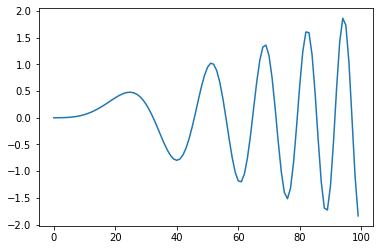

In [40]:
signal = sinusoidal(temps[0:100], amplitude, pulsation)
    
plt.plot(signal)
plt.show()

La fréquence d'échantillonnage de notre signal est le pas:

In [41]:
print(pas)

0.01001001001001001


En Hz (combien de points on a en 1 seconde) :

In [42]:
print(1/pas)

99.9


Connaissant la fréquence d'échantillonnage, on peut générer un tableau de frequences de Fourier correspondant à notre plage temporelle:

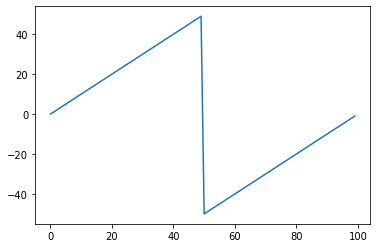

In [43]:
frequence1 = np.fft.fftfreq(np.size(temps[0:100]), pas)

plt.plot(frequence1)
plt.show()
#print(np.size(frequence1))

On remarque la forme symétrique de la fonction nécessaire pour calculer la transformée de Fourier numériquement.

On calcule aussi la transformée de Fourier de notre signal:

In [44]:
signal_fourier = np.fft.fft(signal)

On trace la partie réelle en fonction de la fréquence:

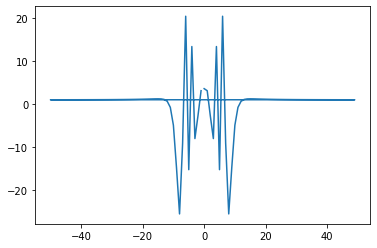

In [45]:
plt.plot(frequence1, np.real(signal_fourier))
plt.show()

On remarque encore la forme symetrique.

En utilisant les valeurs de fréquences positives on défine une focntion permetant de génñerer la densité spectrale de pussance (PSD) d'un bruit coloré sous la dorme d'une loi de puissance : 

In [46]:
def psd(frequence, gamma):
    p = ((frequence[frequence>0])/10)**(gamma) + 1
    return p

On trace un PSD avec gamma < -1:

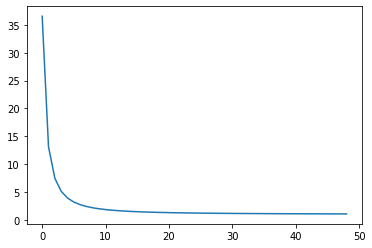

In [47]:
gamma = -1.55
dens1 = psd(frequence1, gamma)
plt.plot(dens1)
plt.show()

C'est la forme attendue d'un bruit coloré dans l'espace de Fourier, i.e, la densité spectrale de puissance d'un bruit coloré. Comme on a vu avant, pour faire la transformée de Fourier inverse, on a besoin (numeriquement parlant) que la fonction soit symetrique. C'est pour ça qu'on ajoute le 0 et on "ajoute" la fonction "miroir" :

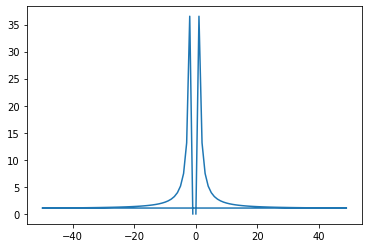

In [48]:
dens1 = np.insert(dens1, 0,  0)
dens1 = np.concatenate((dens1, np.flip(dens1)))

plt.plot(frequence1, dens1)
plt.show()

Un fois que l'on a créé un bruit coloré dans l'espace de Fourier, on va créer un autre bruit coloré dans l'espace de Fourier mais avec la "longueur" de toute notre prise de données, i.e. 10 s en lieu de juste 1s :  

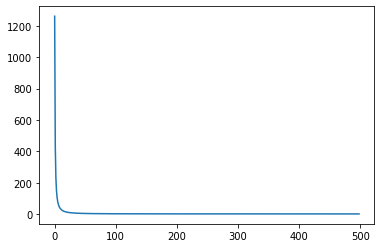

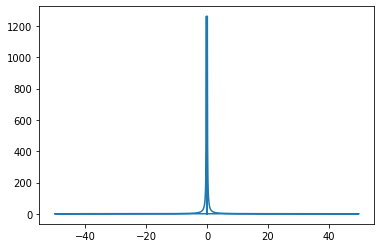

In [49]:
frequence = np.fft.fftfreq(np.size(temps), pas)

dens = psd(frequence, gamma)
plt.plot(dens)
plt.show()

dens = np.insert(dens, 0,  0)
dens = np.concatenate((dens, np.flip(dens)))

plt.plot(frequence, dens)
plt.show()

Maintenant il faut passer de l'espace de Fourier à l'espace réel pour obtenir le bruit coloré :

In [50]:
def bruit(dens):
    bruit_blanc = np.random.normal(0,1,1000)
    fourier_blanc = np.fft.fft(bruit_blanc)
    
    fourier_color = fourier_blanc*np.sqrt(dens)
    bruit_color = np.real(np.fft.ifft(fourier_color))
    
    return bruit_color

Maintenant on ajoute le signal à une position tirée aléatoirement dans cette réalisation de bruit coloré pour obtenir un vecteur de données simules d (données "mesurées" modelisées)

68


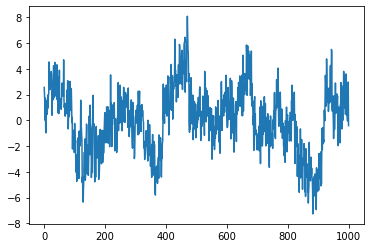

In [52]:
pos = np.random.randint(1000-100)
print(pos)
bruit_color = bruit(dens)
bruit_color[pos:pos+np.size(signal)] += signal

signal_bruit = bruit_color
plt.plot(signal_bruit)
plt.show()

On essaie une amplitude plus grande pour vérifier qu'on peut voir le signal :

873


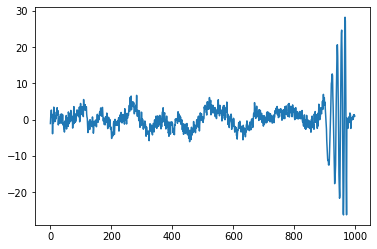

In [53]:
# Penser à faire des fonctions plus haut pour pas faire autant de copier coller ici

big_amp_init = 30
big_amplitude = big_amp_init*temps[0:100]

big_signal = sinusoidal(temps[0:100], big_amplitude, pulsation)

pos = np.random.randint(1000-100)
print(pos)
big_bruit_color = bruit(dens)
big_bruit_color[pos:pos+np.size(big_signal)] += big_signal

big_signal_bruit = big_bruit_color
plt.plot(big_signal_bruit)
plt.show()

Une fois on a notre signal dans du bruit, on va créer le filtre. Pour ça on a besoin d'un model d'un signal et d'un model du bruit, comme on avait vu avec le signal simple et le bruit blanc gaussien. 

On commence en modelisant une signal de la même manière qu'avant. On peut changer l'amplitude mais la pulsation et les pas entre points doit être pareil que le signal "mesuré":

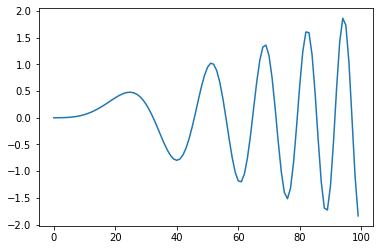

In [54]:
amp_init_model = 2
amplitude_model = amp_init*temps1

signal_model = sinusoidal(temps[0:100], amplitude_model, pulsation)

plt.plot(signal_model)
plt.show()

Dans ce cas là on a decidé de mettre une amplitude un peu plus grande que celle du signal "mesuré"

Pour modeliser le bruit, on utilise la fonction bruit(dens) pour générer du bruit coloré plusieurs fois afin d'estimer la matrice de covariance du bruit.
On crée une matrice de covariance vide 100x100, parce qu'on a besoin que ça soit de la taille du filtre, c'est à dire, du signal modelisé, 1s : 

In [55]:
Cn = np.zeros((100,100))

In [56]:
for i in range(1000):
    bruit_color = bruit(dens)
    Cn += np.dot(np.transpose(bruit_color[None, 0:100]), bruit_color[None, 0:100])

On fait la moyenne des 1000 valeurs, c'est à dire, l'espérance

In [57]:
Cn /= np.size(temps)

On a besoin de la matrice inverse :

In [58]:
cov = np.linalg.inv(Cn)

On vérifie des propiétés de ces matrices: 

In [59]:
if (Cn.all() == np.transpose(Cn).all()):
    print("La matrice de covariance est égal à la matrice de covariance transposée")

La matrice de covariance est égal à la matrice de covariance transposée


In [60]:
I = np.identity(100)
prod = np.dot(Cn,cov)
prod = prod.astype(int)

if prod.all() == I.all():
    print("La matrice de covariance fois son inverse donne l'identité")

La matrice de covariance fois son inverse donne l'identité


Donc, notre filtre devient:

In [61]:
filtre = np.dot(cov, signal_model)

On définit comme dans la partie du signal simple une fonction qui nous permet de faire le produit scalaire entre le filtre et le vrai signal pour trouver les corrélations croisées entre eux :

In [62]:
def cross(ymodel,ysig):
        sizemod = np.size(ymodel)
        sizesig = np.size(ysig)
        
        prod = []
    
        for i in range(sizesig-sizemod):
            p = np.dot(ymodel,ysig[i:(i+sizemod)])
            prod.append(p)
        return prod

On fait les corrélations croisées entre le modèle et les données (signal+bruit):

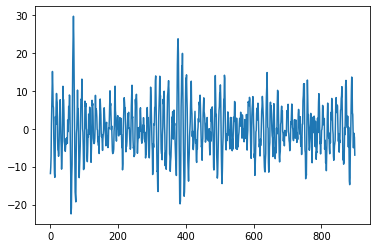

In [63]:
prodat = cross(filtre, signal_bruit)
plt.plot(prodat)
plt.show()

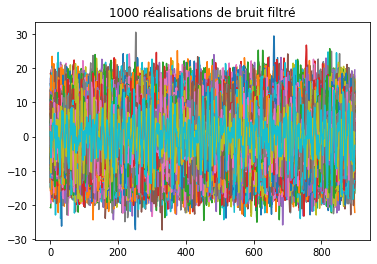

In [64]:
plt.figure()
bruit_filtre = np.zeros(900)
devbr = 0
for i in range(1000):
    bruit_color = bruit(dens)
    prodbruit = cross(filtre, bruit_color)
    bruit_filtre += prodbruit
    dev = np.std(prodbruit)
    devbr+= dev
    plt.title("1000 réalisations de bruit filtré")
    plt.plot(prodbruit)
plt.show()

In [65]:
bruit_filtre = bruit_filtre/1000
devbr = devbr/1000
SNR = prodat/devbr

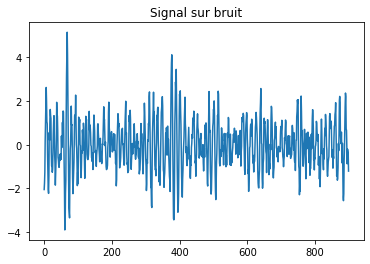

In [66]:
plt.plot(SNR)
plt.title("Signal sur bruit")
plt.show()

In [67]:
def traitement_SNR(SNR):
    
    if np.max(SNR)<4:
        print("Pas de signal détecté")
        return 0
    
    index = np.argmax(SNR)
    #print(index, np.max(SNR))

    #index+= 30
    #print(index)
    
    #l,step = lon(600,1400,1000)
    #l_found = l[index]
    #print("la longueur d'onde trouvée:", l_found)
    
    return index

In [68]:
a = traitement_SNR(SNR)
print(a)
print(pos)

68
873
